### Install Required Libraries

In [1]:
!pip install mediapipe tensorflow opencv-python scikit-learn matplotlib seaborn

### Import Libraries

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from pathlib import Path
import pickle
from tqdm import tqdm

# ตงคา Thai font สำหรบการแสดงผลตวอกษรไทย
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
sns.set_style('whitegrid')

### Setup Paths and Load Model

In [ ]:

dataset_root = './dataset'
unseen_set_path = os.path.join(dataset_root, 'Unseen_set')
model_path = os.path.join(dataset_root, 'model', 'best_sign_model.h5')

print(f"Dataset path: {os.path.exists(unseen_set_path)}")
print(f"Model path: {os.path.exists(model_path)}")

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print(" โมเดลโหลดสำเรจ")
    print(f"Input shape: {model.input_shape}")
    print(f"Output shape: {model.output_shape}")
else:
    print(f" ไมพบไฟลโมเดล: {model_path}")

Dataset path: True
Model path: True


 โมเดลโหลดสำเรจ
Input shape: (None, 224, 224, 3)
Output shape: (None, 15)


### Load Class Names

In [ ]:
cache_path = os.path.join(dataset_root, 'Training set', '_cached_data.pkl')

if os.path.exists(cache_path):
    with open(cache_path, 'rb') as f:
        data_list, class_names = pickle.load(f)
    print(f" โหลด class names จาก cache สำเรจ")
    print(f"จำนวน classes: {len(class_names)}")
    print(f"Classes: {sorted(class_names)}")
else:
    print(f" ไมพบ cache file, กำลงโหลด classes จาก Unseen_set...")
    unseen_dirs = os.listdir(unseen_set_path)
    class_names = [d for d in unseen_dirs if os.path.isdir(os.path.join(unseen_set_path, d))]
    print(f"Classes: {sorted(class_names)}")

 ไมพบ cache file, กำลงโหลด classes จาก Unseen_set...
Classes: ['BOR_BAI_MAI', 'DOR_DEK', 'FOR_FUN', 'HOR_HEEP', 'KO_KAI', 'LOR_LING', 'MOR_MAH', 'NOR_NOO', 'OR_ANG', 'POR_PHAN', 'RAO_RUEA', 'SOR_SUEA', 'TOR_TAO', 'WOR_WAEN', 'YOR_YAK']


### Initialize MediaPipe Hand Detector

In [ ]:

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print(" MediaPipe Hand Detector")

 MediaPipe Hand Detector


### Helper Functions for Hand Detection and Preprocessing

In [ ]:
def detect_hand_bbox(image):
    """
    ใช MediaPipe เพอตรวจจบมอและคนคา bounding box
    """
    try:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)
        
        if results.multi_hand_landmarks:
            h, w = image.shape[:2]
            hand_landmarks = results.multi_hand_landmarks[0]
            
            x_coords = [lm.x for lm in hand_landmarks.landmark]
            y_coords = [lm.y for lm in hand_landmarks.landmark]

            margin = 10
            x_min = int(max(0, min(x_coords) * w - margin))
            y_min = int(max(0, min(y_coords) * h - margin))
            x_max = int(min(w, max(x_coords) * w + margin))
            y_max = int(min(h, max(y_coords) * h + margin))
            
            return (x_min, y_min, x_max, y_max)
    except Exception as e:
        pass
    
    return None

def preprocess_image(image_path, target_size=224):
    """
    โหลดและปรบปรงรปภาพสำหรบโมเดล
    """
    try:

        image = cv2.imread(image_path)
        if image is None:
            return None, None, False
        
        h, w = image.shape[:2]
        

        bbox = detect_hand_bbox(image)
        
        if bbox:
            x1, y1, x2, y2 = bbox
            roi = image[y1:y2, x1:x2]
            hand_detected = True
        else:
            crop_size = min(h, w)
            x_start = (w - crop_size) // 2
            y_start = (h - crop_size) // 2
            roi = image[y_start:y_start+crop_size, x_start:x_start+crop_size]
            hand_detected = False
        
        if roi.size == 0:
            return None, None, False
        
        resized = cv2.resize(roi, (target_size, target_size))
        
        rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        normalized = (rgb - mean) / std
        
        return normalized, hand_detected, True
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None, None, False

def predict_image(image_data):
    """
    ทำการ predict รปภาพ
    """
    if image_data is None:
        return None, None
    
    # เพมมต batch
    batch = np.expand_dims(image_data, axis=0)
    
    # Predict
    predictions = model.predict(batch, verbose=0)[0]
    predicted_idx = np.argmax(predictions)
    confidence = predictions[predicted_idx]
    
    return predicted_idx, confidence

print(" Helper functions")

 Helper functions


### Process Unseen_set and Collect Results

In [ ]:
true_labels = []
pred_labels = []
confidences = []
hand_detection_stats = {'detected': 0, 'not_detected': 0}
results_by_class = defaultdict(lambda: {'correct': 0, 'total': 0})

class_names_sorted = sorted(class_names)
total_images = 0

for class_name in class_names_sorted:
    class_path = os.path.join(unseen_set_path, class_name)
    if os.path.isdir(class_path):
        image_count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        total_images += image_count

print(f"พบทงหมด {total_images} รปภาพ")
print(f"จำนวน classes: {len(class_names_sorted)}")
print("\nกำลงประมวลผล...")

with tqdm(total=total_images, desc="Processing images") as pbar:
    for class_name in class_names_sorted:
        class_path = os.path.join(unseen_set_path, class_name)
        
        if not os.path.isdir(class_path):
            continue

        true_class_idx = class_names_sorted.index(class_name)
        
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        for image_file in image_files:
            image_path = os.path.join(class_path, image_file)

            image_data, hand_detected, success = preprocess_image(image_path)
            
            if success and image_data is not None:
                if hand_detected:
                    hand_detection_stats['detected'] += 1
                else:
                    hand_detection_stats['not_detected'] += 1

                pred_idx, confidence = predict_image(image_data)
                
                if pred_idx is not None:
                    true_labels.append(true_class_idx)
                    pred_labels.append(pred_idx)
                    confidences.append(confidence)

                    results_by_class[class_name]['total'] += 1
                    if pred_idx == true_class_idx:
                        results_by_class[class_name]['correct'] += 1
            
            pbar.update(1)

print("\n ประมวลผลเสรจ")

พบทงหมด 300 รปภาพ
จำนวน classes: 15

กำลงประมวลผล...


Processing images:   0%|          | 0/300 [00:00<?, ?it/s]c:\Users\BestyBest\AppData\Local\Programs\Python\Python311\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing images: 100%|██████████| 300/300 [00:35<00:00,  8.55it/s]


 ประมวลผลเสรจ


### Calculate Overall Statistics

In [ ]:
total_images_processed = len(true_labels)
correct_predictions = sum([1 for t, p in zip(true_labels, pred_labels) if t == p])
overall_accuracy = (correct_predictions / total_images_processed * 100) if total_images_processed > 0 else 0

print("="*60)
print("OVERALL STATISTICS")
print("="*60)
print(f"Total Images Processed: {total_images_processed}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Incorrect Predictions: {total_images_processed - correct_predictions}")
print(f"\n Overall Accuracy: {overall_accuracy:.2f}%")
print(f"\nHand Detection Stats:")
print(f"  - Hands Detected: {hand_detection_stats['detected']} ({hand_detection_stats['detected']/total_images_processed*100:.2f}%)")
print(f"  - Hands Not Detected: {hand_detection_stats['not_detected']} ({hand_detection_stats['not_detected']/total_images_processed*100:.2f}%)")

OVERALL STATISTICS
Total Images Processed: 300
Correct Predictions: 245
Incorrect Predictions: 55

 Overall Accuracy: 81.67%

Hand Detection Stats:
  - Hands Detected: 299 (99.67%)
  - Hands Not Detected: 1 (0.33%)


### Per-Class Accuracy

In [11]:
print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

class_accuracies = {}
for class_name in sorted(results_by_class.keys()):
    stats = results_by_class[class_name]
    if stats['total'] > 0:
        accuracy = (stats['correct'] / stats['total']) * 100
        class_accuracies[class_name] = accuracy
        print(f"{class_name:20} : {stats['correct']:3}/{stats['total']:3} ({accuracy:6.2f}%)")

# สรปคาเฉลย
avg_per_class_accuracy = np.mean(list(class_accuracies.values())) if class_accuracies else 0
print(f"\nMean Per-Class Accuracy: {avg_per_class_accuracy:.2f}%")


PER-CLASS ACCURACY
BOR_BAI_MAI          :  20/ 20 (100.00%)
DOR_DEK              :  20/ 20 (100.00%)
FOR_FUN              :  20/ 20 (100.00%)
HOR_HEEP             :  20/ 20 (100.00%)
KO_KAI               :  15/ 20 ( 75.00%)
LOR_LING             :  19/ 20 ( 95.00%)
MOR_MAH              :  20/ 20 (100.00%)
NOR_NOO              :  12/ 20 ( 60.00%)
OR_ANG               :   1/ 20 (  5.00%)
POR_PHAN             :  19/ 20 ( 95.00%)
RAO_RUEA             :  13/ 20 ( 65.00%)
SOR_SUEA             :  18/ 20 ( 90.00%)
TOR_TAO              :  17/ 20 ( 85.00%)
WOR_WAEN             :  14/ 20 ( 70.00%)
YOR_YAK              :  17/ 20 ( 85.00%)

Mean Per-Class Accuracy: 81.67%


### Visualize Confusion Matrix

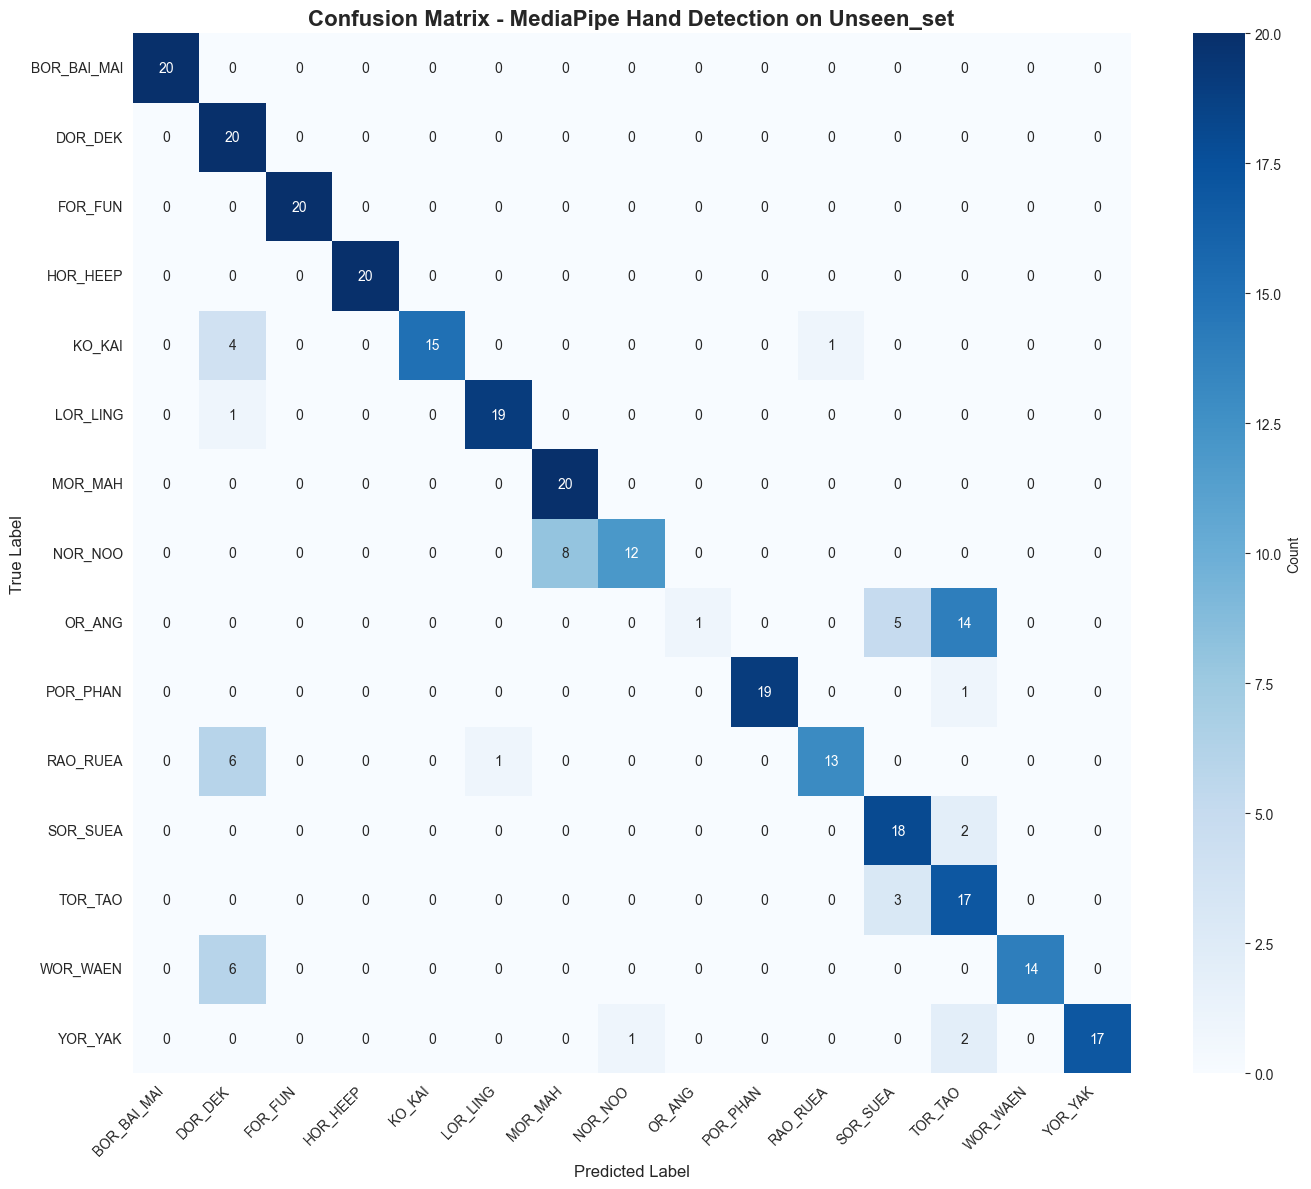

 Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names_sorted,
    yticklabels=class_names_sorted,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - MediaPipe Hand Detection on Unseen_set', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix saved as 'confusion_matrix.png'")

### Detailed Classification Report

In [ ]:
report = classification_report(
    true_labels,
    pred_labels,
    target_names=class_names_sorted,
    digits=4
)

print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORT")
print("="*60)
print(report)


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

 BOR_BAI_MAI     1.0000    1.0000    1.0000        20
     DOR_DEK     0.5405    1.0000    0.7018        20
     FOR_FUN     1.0000    1.0000    1.0000        20
    HOR_HEEP     1.0000    1.0000    1.0000        20
      KO_KAI     1.0000    0.7500    0.8571        20
    LOR_LING     0.9500    0.9500    0.9500        20
     MOR_MAH     0.7143    1.0000    0.8333        20
     NOR_NOO     0.9231    0.6000    0.7273        20
      OR_ANG     1.0000    0.0500    0.0952        20
    POR_PHAN     1.0000    0.9500    0.9744        20
    RAO_RUEA     0.9286    0.6500    0.7647        20
    SOR_SUEA     0.6923    0.9000    0.7826        20
     TOR_TAO     0.4722    0.8500    0.6071        20
    WOR_WAEN     1.0000    0.7000    0.8235        20
     YOR_YAK     1.0000    0.8500    0.9189        20

    accuracy                         0.8167       300
   macro avg     0.8814    0.8167    0.8024     

### Final Summary Report

In [ ]:
print("\n" + "#"*60)
print("#" + " "*58 + "#")
print("#" + "  FINAL SUMMARY REPORT - MediaPipe Hand Detection".center(58) + "#")
print("#" + " "*58 + "#")
print("#"*60)

print(f"\n DATASET INFORMATION:")
print(f"  - Total Images: {total_images_processed}")
print(f"  - Number of Classes: {len(class_names_sorted)}")
print(f"  - Classes: {', '.join(class_names_sorted)}")

print(f"\n HAND DETECTION RESULTS:")
print(f"  - Hands Detected: {hand_detection_stats['detected']} ({hand_detection_stats['detected']/total_images_processed*100:.2f}%)")
print(f"  - Not Detected: {hand_detection_stats['not_detected']} ({hand_detection_stats['not_detected']/total_images_processed*100:.2f}%)")

print(f"\n ACCURACY METRICS:")
print(f"  - Overall Accuracy: {overall_accuracy:.2f}%")
print(f"  - Mean Per-Class Accuracy: {avg_per_class_accuracy:.2f}%")
print(f"  - Correct Predictions: {correct_predictions}/{total_images_processed}")

print(f"\n CONFIDENCE SCORE STATISTICS:")
print(f"  - Mean Confidence: {np.mean(confidences):.4f}")
print(f"  - Median Confidence: {np.median(confidences):.4f}")
print(f"  - Std Deviation: {np.std(confidences):.4f}")
print(f"  - Min Confidence: {np.min(confidences):.4f}")
print(f"  - Max Confidence: {np.max(confidences):.4f}")

print(f"\n OUTPUT FILES GENERATED:")
print(f"  - confusion_matrix.png")
print(f"  - per_class_accuracy.png")
print(f"  - confidence_analysis.png")

print(f"\n" + "#"*60)


############################################################
#                                                          #
#      FINAL SUMMARY REPORT - MediaPipe Hand Detection     #
#                                                          #
############################################################

 DATASET INFORMATION:
  - Total Images: 300
  - Number of Classes: 15
  - Classes: BOR_BAI_MAI, DOR_DEK, FOR_FUN, HOR_HEEP, KO_KAI, LOR_LING, MOR_MAH, NOR_NOO, OR_ANG, POR_PHAN, RAO_RUEA, SOR_SUEA, TOR_TAO, WOR_WAEN, YOR_YAK

 HAND DETECTION RESULTS:
  - Hands Detected: 299 (99.67%)
  - Not Detected: 1 (0.33%)

 ACCURACY METRICS:
  - Overall Accuracy: 81.67%
  - Mean Per-Class Accuracy: 81.67%
  - Correct Predictions: 245/300

 CONFIDENCE SCORE STATISTICS:
  - Mean Confidence: 0.9265
  - Median Confidence: 0.9935
  - Std Deviation: 0.1305
  - Min Confidence: 0.3201
  - Max Confidence: 1.0000

 OUTPUT FILES GENERATED:
  - confusion_matrix.png
  - per_class_accuracy.png
  - confidence_a